<a href="https://colab.research.google.com/github/hariskhan-hk/Tumor_Classification/blob/main/Training/Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumor Classification

## I. Import Required Dependecies

In [ ]:
import os
import glob
from IPython.display import Image as IPImage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image           # Pillow - for image processing tasks

# TensorFlow - for deep learning operations and model management
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Keras - for building and training neural network models
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import models, optimizers
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import DenseNet121
from keras.applications.densenet import DenseNet121, preprocess_input

# scikit-learn - for data splitting and model evaluation utilities
from sklearn.model_selection import train_test_split

2025-04-28 10:44:18.432277: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 10:44:18.437469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-28 10:44:18.437490: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## II. Read Dataset

### Path to the Directory Containing the Images

In [ ]:
dataset = './Dataset_BUSI_with_GT'

pd.DataFrame(
    os.listdir(dataset),
    columns=['Classes']
)

,Classes
0,benign
1,malignant
2,normal


### Directory Paths Containing DataSet

In [ ]:
# Get a list of the file paths in the 'dataset' directory
train_files = [i for i in glob.glob(dataset + "/*/*")]

# Randomly shuffle the list of file paths
np.random.shuffle(train_files)

# Extract labels from the directory names of each file path
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]

# Combine file paths & its corresponding labels into a list of tuples
data = zip(train_files, labels)

# Create a Pandas DataFrame with 2 columns. "Path" column contains file paths, & "Label" column contains corresponding labels
training_data = pd.DataFrame(data, columns=["Path", "Label"])

# Display the contents of the DataFrame
training_data

,Path,Label
0,./Dataset_BUSI_with_GT/benign/benign (32)_mask...,benign
1,./Dataset_BUSI_with_GT/benign/benign (262)_mas...,benign
2,./Dataset_BUSI_with_GT/normal/normal (125)_mas...,normal
3,./Dataset_BUSI_with_GT/normal/normal (10)_mask...,normal
4,./Dataset_BUSI_with_GT/benign/benign (218).png,benign
...,...,...
1573,./Dataset_BUSI_with_GT/malignant/malignant (61...,malignant
1574,./Dataset_BUSI_with_GT/malignant/malignant (17...,malignant
1575,./Dataset_BUSI_with_GT/normal/normal (102).png,normal
1576,./Dataset_BUSI_with_GT/benign/benign (338)_mas...,benign


## III. Data Visualization

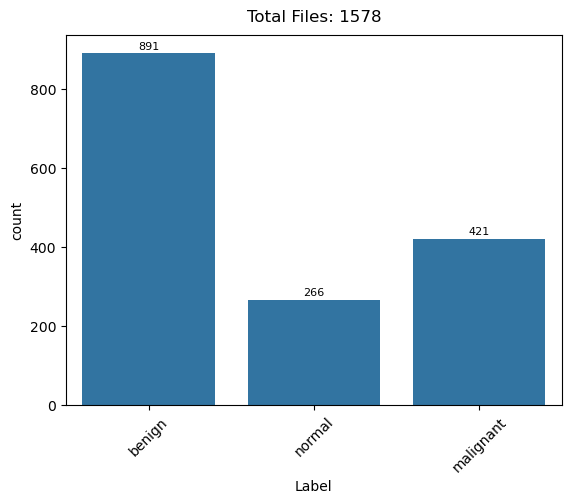

In [ ]:
# Create a countplot() using Seaborn, where x-axis represents the "Label" column of the training_data DataFrame
ax = sns.countplot(x=training_data["Label"])

# Display count inside each bar as integers
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a title with the total count of files
plt.title(f'Total Files: {len(training_data)}', pad=10)

# Show the plot
plt.show()

## IV. Collect Data Paths & Labels from Directory Structure

In [ ]:
data_paths = []
labels = []

main_dirs = os.listdir(dataset)
for folder_name in main_dirs:
    folder_path = os.path.join(dataset, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

## V. Data Preprocessing

In [ ]:
# Set the batch size for training
batch_size = 16

# Define the target image size for preprocessing
image_size = (256, 256)

# Specify the number of color channels in the images (3 for RGB)
num_channels = 3

# Create the image shape tuple based on the specified size and channels
image_shape = (image_size[0], image_size[1], num_channels)

# Create a Pandas Series containing file paths with the name 'Path'
data_dirs = pd.Series(data_paths, name='Path')

# Create a Pandas Series containing corresponding labels with the name 'Label'
classes = pd.Series(labels, name='Label')

# Split the dataset into training and validation-test sets
train_df, val_test_df = train_test_split(
    training_data,
    train_size=0.8,
    shuffle=True,
    random_state=123
)

# Split the val_test_df set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df,
    train_size=0.5,
    shuffle=True,
    random_state=123
)

# ImageDataGenerator configuration, normalize pixel values from 0-255 to 0-1.
datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Convert the 'Label' column to string type
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

# Create generators for training and validation
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size, # resize to image_size
    class_mode='categorical', # organize labels using categorical mode (for multi-class classification)
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size # use batches of size batch_size
)

valid_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)


# ----- Show full test image paths -----
# Convert test labels to string type
test_df['Label'] = test_df['Label'].astype(str)

# Optional: Set pandas to show full file paths
pd.set_option('display.max_colwidth', None)

# Display first 10 image paths in the test set
print("Sample test image paths:")
for path in test_df['Path'].head(10):
    print(path)

Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.
Sample test image paths:
./Dataset_BUSI_with_GT/normal/normal (85).png
./Dataset_BUSI_with_GT/malignant/malignant (183)_mask.png
./Dataset_BUSI_with_GT/benign/benign (197).png
./Dataset_BUSI_with_GT/malignant/malignant (173).png
./Dataset_BUSI_with_GT/malignant/malignant (104).png
./Dataset_BUSI_with_GT/malignant/malignant (115)_mask.png
./Dataset_BUSI_with_GT/malignant/malignant (62).png
./Dataset_BUSI_with_GT/benign/benign (364).png
./Dataset_BUSI_with_GT/benign/benign (401).png
./Dataset_BUSI_with_GT/malignant/malignant (49).png


### Display Class Names

In [ ]:
# Get the class indices (mapping of the class names to numerical indices) from the training generator
class_indices = train_generator.class_indices
print(class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


### Visualize a Subset of Images from the DataSet

(611, 656)
(401, 471)
(471, 558, 3)
(485, 501, 3)
(396, 602, 3)
(457, 555)
(495, 548)
(587, 602, 3)


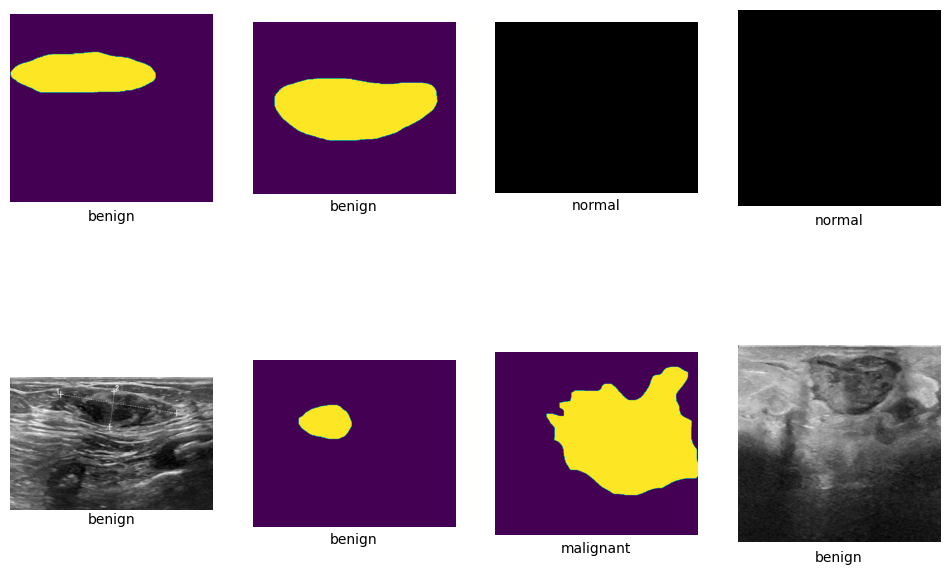

In [ ]:
# Set the number of rows and columns for the subplot grid
no_of_rows = 2
no_of_columns = 4

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(12, 8))

# Iterate through the rows
for i in range(no_of_rows):
    # Iterate through the columns
    for j in range(no_of_columns):
        # Calculate the index for accessing the data
        index = i * no_of_columns + j

        # Check if the index is within the bounds of the data
        if index < len(training_data):

            # Open the image using the PIL library
            im = Image.open(training_data.iloc[index]['Path'])

            # Convert the PIL image to a NumPy array
            img = np.array(im)

            # Print the shape of the image array
            print(img.shape)

            # Display the image on the subplot at position (i, j)
            axes[i, j].imshow(img)

            # Turn off axis labels for better visualization
            axes[i, j].axis('off')

            # Get the label for the current image and display it as text
            label = training_data.iloc[index]['Label']
            axes[i, j].text(0.5, -0.1, label, ha='center', transform=axes[i, j].transAxes)

# Show the entire subplot grid
plt.show()

## VI. Build Model

In [ ]:
# Load the DenseNet-121 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = DenseNet121(
    weights='./model/weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,     # Excludes the final Dense layers used for ImageNet classification
    input_shape=(256, 256, 3)  # Specifies the input shape of the images
)

# Freeze all layers of the base DenseNet model to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()

# Add the DenseNet base model as the feature extractor
model.add(base_model)

# Flatten the output feature maps to feed into fully connected layers
model.add(Flatten())

# Add fully connected layers to learn from extracted features
model.add(Dense(1024, activation='relu'))  # First dense layer with ReLU activation
model.add(Dense(1024, activation='relu'))  # Second dense layer
model.add(Dense(512, activation='relu'))   # Third dense layer

# Add another dense layer before the final output layer
model.add(Dense(128, activation='relu'))

# Final classification layer with softmax activation for 3 output classes
model.add(Dense(3, activation='softmax'))

# Display a summary of the model architecture
model.summary()

2025-04-21 15:54:26.645966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-21 15:54:26.646266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-21 15:54:26.646344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-04-21 15:54:26.646382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-04-21 15:54:26.646417: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 3)                 3

### Create Model Checkpoint Callback to Save Best Model

In [ ]:
# Define the path to save the best model checkpoint
checkpoint_path = "./model/model.keras"


# Create a ModelCheckpoint callback
# This callback saves the model when validation accuracy improves
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',              # Save based on the maximum validation accuracy
    verbose=1                # Display progress information
)

## VII. Compile Model

In [ ]:
# Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

## VIII. Train Model

In [ ]:
# Train the model using the fit() method
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 2.3395 - accuracy: 0.7103
Epoch 1: val_accuracy improved from -inf to 0.82639, saving model to ./model/model.keras
78/78 [==============================] - 67s 821ms/step - loss: 2.3395 - accuracy: 0.7103 - val_loss: 0.5330 - val_accuracy: 0.8264
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8732
Epoch 2: val_accuracy did not improve from 0.82639
78/78 [==============================] - 64s 819ms/step - loss: 0.3199 - accuracy: 0.8732 - val_loss: 0.4630 - val_accuracy: 0.8125
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9278
Epoch 3: val_accuracy improved from 0.82639 to 0.86806, saving model to ./model/model.keras
78/78 [==============================] - 64s 825ms/step - loss: 0.1975 - accuracy: 0.9278 - val_loss: 0.3314 - val_accuracy: 0.8681
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9

### Display Training History

In [ ]:
# Create a Pandas DataFrame containing the training history (metrics) of the model
train_history = pd.DataFrame(history.history)

# Add a new column 'Epoch' with values from 1 to the number of epochs
train_history['Epoch'] = range(1, len(train_history) + 1)

# Reorder columns for clarity
train_history = train_history[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

# Display the DataFrame
train_history

,Epoch,loss,accuracy,val_loss,val_accuracy
0,1,2.339533,0.710273,0.533037,0.826389
1,2,0.319932,0.873194,0.462961,0.812500
2,3,0.197482,0.927769,0.331375,0.868056
3,4,0.148474,0.950241,0.649699,0.861111
4,5,0.112286,0.960674,0.770571,0.833333
5,6,0.076852,0.975923,0.481095,0.875000
6,7,0.064014,0.979133,0.604878,0.861111
7,8,0.122582,0.969502,0.563221,0.868056
8,9,0.034036,0.984751,0.785782,0.854167
9,10,0.073015,0.979133,0.400852,0.902778


## IX. Evaluate Model (Train & Validation Set)

In [ ]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)

# Convert accuracy to percentage
train_accuracy_percentage = train_accuracy * 100
val_accuracy_percentage = val_accuracy * 100

# Create a Pandas DataFrame to display the results
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [train_loss, val_loss],
    'Accuracy': [f'{train_accuracy_percentage:.2f}%', f'{val_accuracy_percentage:.2f}%']
})

# Display the evaluation results DataFrame
evaluation_results

9/9 [==============================] - 5s 525ms/step - loss: 1.1850 - accuracy: 0.8958


,Set,Loss,Accuracy
0,Train,0.000003,100.00%
1,Validation,1.184960,89.58%


### Plot Loss & Accuracy

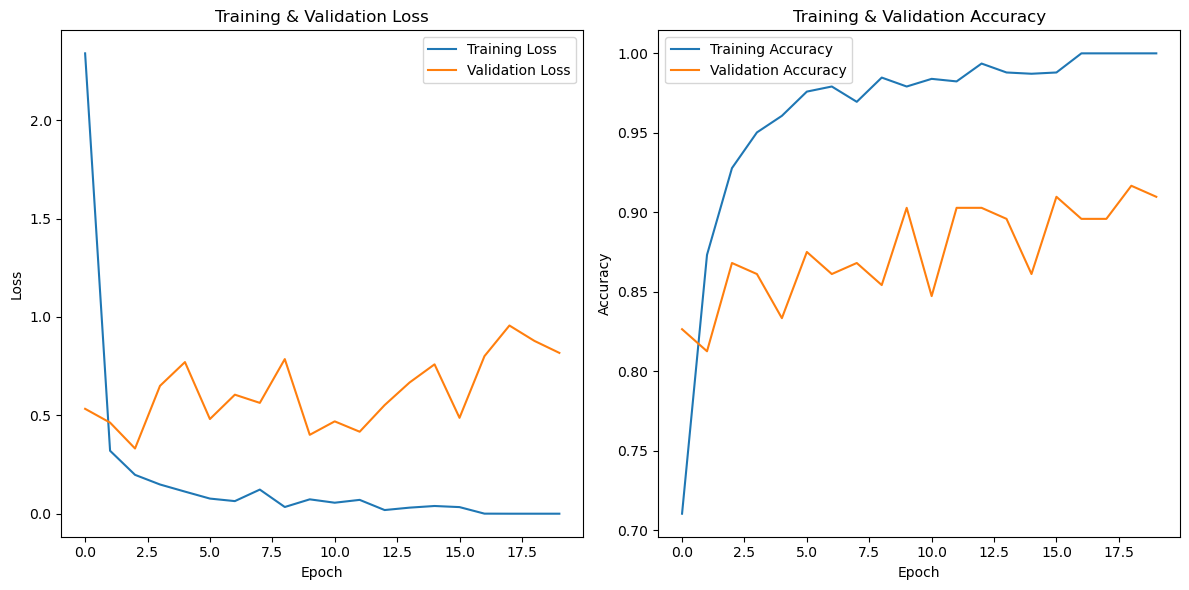

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## X. Download Trained Model

In [ ]:
# from google.colab import files

# # Path to the file you want to download
# file_path = '/content/working/model.keras'

# # Download the file
# files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## XI. Test Model

### Load the Trained Model

In [ ]:
from tensorflow.keras.models import load_model

try:
    model = load_model('./model/model.keras')
    print("Loaded existing model successfully")
except:
    print("No saved model found. You need to train the model first.")


Loaded existing model successfully


### Image Processing for Testing

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

test_image_path = './Dataset_BUSI_with_GT/benign/benign (26).png'
preprocessed_image = preprocess_image(test_image_path)

In [ ]:
predictions = model.predict(preprocessed_image)

predicted_class_index = np.argmax(predictions, axis=1)[0]

class_labels = {
    0: 'Benign',
    1: 'Malignant',
    2: 'Normal',
}
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_label}")
print(f"Prediction Confidence: {predictions[0][predicted_class_index]:.2f}")

1/1 [==============================] - 1s 1s/step
Predicted Class: Benign
Prediction Confidence: 1.00
